#  Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug to set the random seed
* SegmentationMapsOnImage from imgaug to augment the segmentation map

In [1]:
from pathlib import Path

import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

#  DataSet Creation
We need to implement the following functionality:
1. Create a list of all 2D slices. To do so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [2]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        #####################################################
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torch
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        # Note that pytorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height and W to Width.
        # As our data is of shape (HxW) we need to manually add the C axis by using expand_dims.
        # The batch dimension is later added by the dataloader

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
        

In [3]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa


In [4]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])


In [5]:
# Create the dataset object
path = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\Preprocessed\train")
dataset = CardiacDataset(path, seq)

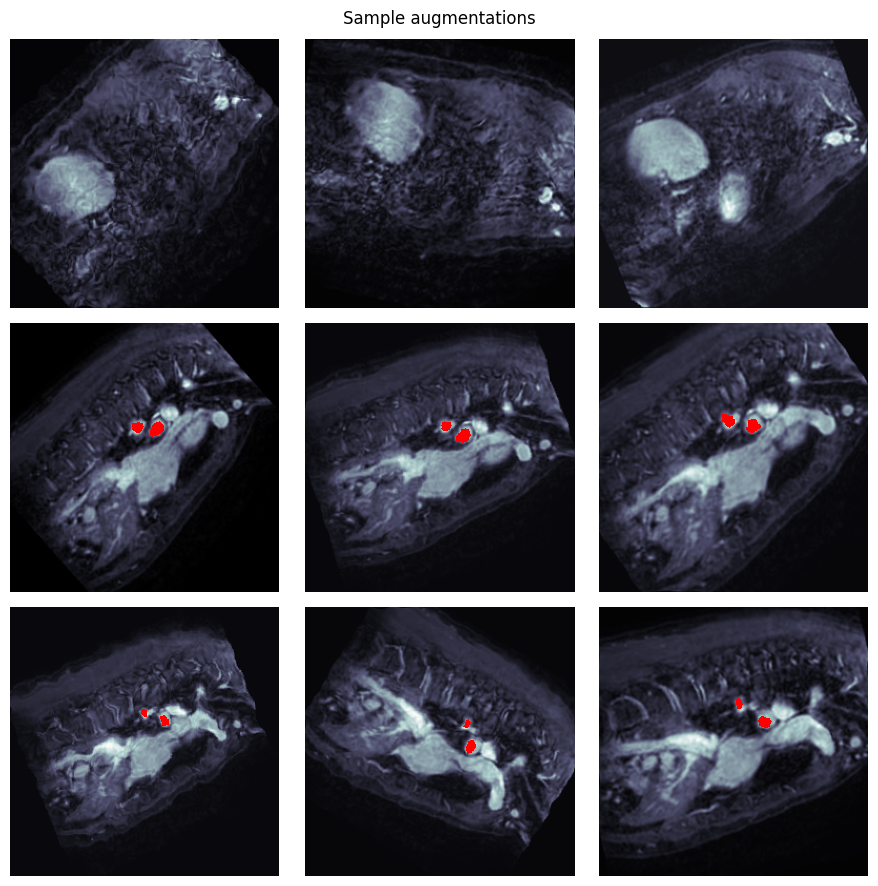

In [6]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),  # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

# Create the dataset object
path = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\Preprocessed\\train")
dataset = CardiacDataset(path, seq)

fig, axis = plt.subplots(3, 3, figsize=(9, 9))

# Iterate over the dataset using range(len(dataset))
for i in range(3):
    for j in range(3):
        slice, mask = dataset[i * 3 + j]
        mask_ = np.ma.masked_where(mask == 0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()
plt.show()

## Imports:
1. torch for model creation

In [7]:
import torch

In [8]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)
    

#  UNET
The idea behind a UNET is the Encoder-Decoder architecture with additional skip-connctions on different levels:<br />
The encoder reduces the size of the feature maps by using downconvolutional layers.
The decoder reconstructs a mask of the input shape over several layers by upsampling.
Additionally skip-connections allow a direct information flow from the encoder to the decoder on all intermediate levels of the UNET.
This allows for a high quality of the produced mask and simplifies the training process.

![title]("C:\\Users\\riddhi\\OneDrive\\Pictures\\Screenshots\\unet.png")


In [9]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

#  Testing

In [10]:
model = UNet()

In [11]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])

# Imports:

* pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* Our dataset and model



In [12]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

#from dataset import CardiacDataset
#from model import UNet

In [13]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [14]:
# Create the dataset objects
train_path = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\Preprocessed\\train")
val_path = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\Preprocessed\\val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [15]:
batch_size = 8
num_workers = 3

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


# Custom Loss
Often segmentation models perform better when using a Dice Loss instead of Cross-Entropy.<br />
The Dice Loss is defined as:
$$ L(\hat{y}, y) = 1-\frac{2 |\hat{y} \cap y|}{|\hat{y}| + |y|}$$

The intersection can be easily computed by $\hat{y}$ * $y$ as both variables are binary masks.

You can read more about the Dice Score here:
https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [16]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


# Full Segmentation Model

We will now combine everything into the full pytorch lightning model

In [17]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [18]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [20]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    #filepath = 'checcpoint.ckpt',
    monitor='Val Dice',
    save_top_k=10,
    mode='min')

In [21]:
import torch

print(torch.cuda.is_available())

False


In [22]:
# Create the checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\logs',
    monitor='Val Dice',
    save_top_k=10,
    mode='min',
    save_weights_only=True)

# Create the trainer
trainer = pl.Trainer(accelerator="cpu", logger=pl.loggers.TensorBoardLogger(save_dir="C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],max_epochs=75, num_sanity_val_steps=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#  Evaluation:
Let's evaluate the model

* nibabel to load a full scan
* tqdm for progress bar when validating the model
* celluloid for easy video generation


In [23]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [24]:
model = AtriumSegmentation.load_from_checkpoint("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\weights\\70.ckpt")

C:\Users\riddhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\utilities\migration\migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\riddhi\OneDrive\Desktop\Codes\06-Atrium-Segmentation\weights\70.ckpt`


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [26]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [27]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.9539)

In [28]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9538518190383911


# Visualisation

In [30]:
subject = Path("C:\\Users\\riddhi\\OneDrive\\Desktop\\Codes\\06-Atrium-Segmentation\\Task02_Heart\\imagesTs\\la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [31]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [32]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [33]:
standardized_scan.shape

(256, 256, 140)

In [ ]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
